### Notebook to examine how temperature impacts developmental stage at cell, tissue, and embryo-levels

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import glob2 as glob
import os

Load in colData from sequencing experiment. This has been exported to a csv file

In [2]:
# set paths
project_root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/hotfish/"
data_folder = os.path.join(project_root, "built_data", "20240813", "")

fig_folder = os.path.join(project_root, "figures", "20240813_staging", "")
os.makedirs(fig_folder, exist_ok=True)

# load data
col_df = pd.read_csv(data_folder + "col_data.csv")
# col_df["tissue"] = pd.Categorical(col_df["tissue"])
col_df.head()

cell  Size_Factor  n.umi  perc_mitochondrial_umis  \
0   A04_G01_P01-A01_LIG10     1.175448    289                 0.346021   
1  A04_G01_P01-A07_LIG100     0.732113    180                 0.000000   
2   A04_G01_P01-B07_LIG11     0.597892    147                 1.360544   
3  A04_G01_P01-C03_LIG182     1.838417    452                 0.000000   
4  A04_G01_P01-D04_LIG118     3.172489    780                 0.128205   

   intron_fraction P5_barcode P7_barcode RT_barcode Ligation_barcode RT_plate  \
0         0.892734        A04        G01    P01-A01            LIG10      P01   
1         0.827778        A04        G01    P01-A07           LIG100      P01   
2         0.789116        A04        G01    P01-B07            LIG11      P01   
3         0.823009        A04        G01    P01-C03           LIG182      P01   
4         0.842308        A04        G01    P01-D04           LIG118      P01   

   ...  count_per_embryo  log.n.umi  max_nn_dist  min_nn_dist  \
0  ...              1675   2.460898     0.056616     0.030793   
1  ...              1522   2.255273     0.045397     0.012805   
2  ...              2054   2.167317     0.045950     0.020339   
3  ...              1125   2.655138     0.041147     0.018660   
4  ...              2173   2.892095     0.033749     0.015089   

  projection_group partition_col         cell_type mean_nn_time    tissue  \
0         midbrain             2  MHB, progenitor          27.0  midbrain   
1         midbrain             2  MHB, progenitor          35.6  midbrain   
2         midbrain             2  MHB, progenitor          47.4  midbrain   
3         midbrain             2  MHB, progenitor          21.6  midbrain   
4         midbrain             2  MHB, progenitor          21.0  midbrain   

   sample  
0       1  
1       1  
2       1  
3       1  
4       1  

[5 rows x 49 columns]

#### Step 1: look at whole-embryo transcriptional stage by temp and timepoint

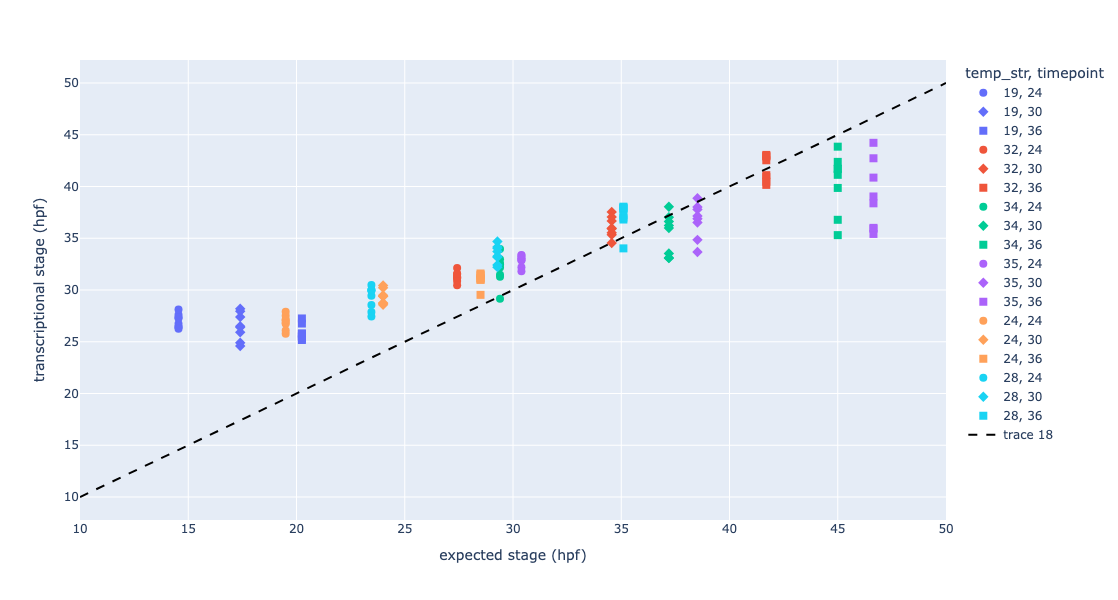

In [9]:
# get average time for each embryo
emb_stage_df = col_df.loc[:, ["embryo_ID", "temp", "timepoint", "mean_nn_time"]].groupby(
                    ["embryo_ID", "temp", "timepoint"]).mean("mean_nn_time").reset_index()

emb_stage_df["temp_str"] = emb_stage_df["temp"].astype(str)

# get predicted stage using linear formula
emb_stage_df["predicted_stage"] = 6 + (emb_stage_df["timepoint"] - 6)*(0.055*emb_stage_df["temp"]-0.57)

# make reference x=y diag
ref_vec = np.linspace(10, 50)

fig = px.scatter(emb_stage_df, x="predicted_stage", y="mean_nn_time", color="temp_str", symbol="timepoint")
fig.add_trace(go.Scatter(x=ref_vec, y=ref_vec, mode="lines", line=dict(color="black", width=2, dash="dash")))
fig.update_traces(marker=dict(size=8))

# Update axis titles
fig.update_layout(
    xaxis_title="expected stage (hpf)",
    yaxis_title="transcriptional stage (hpf)"
)

fig.update_layout(width=800, height=600) 
fig.show()

fig.write_image(fig_folder + "embryo_transcriptional_stage_vs_predicted.png", scale=2)
fig.write_html(fig_folder + "embryo_transcriptional_stage_vs_predicted.html")

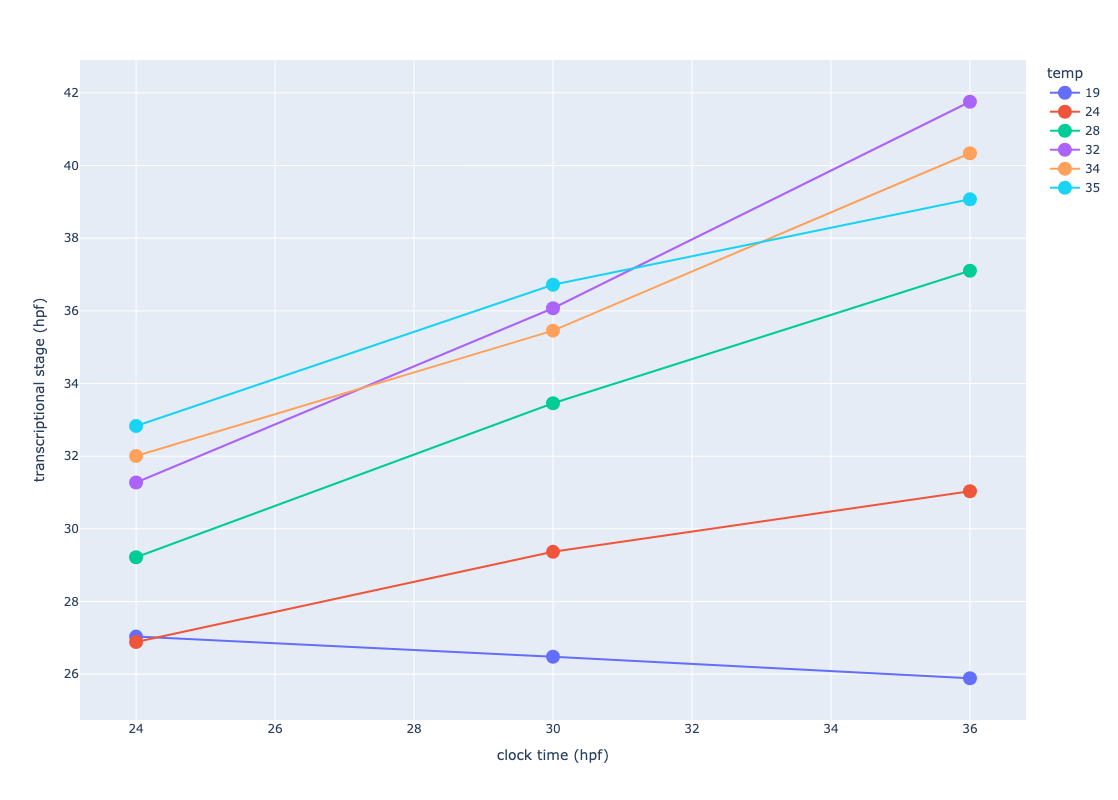

In [10]:
grp_stage_df = emb_stage_df.loc[:, ["temp", "temp_str", "timepoint", "mean_nn_time", "predicted_stage"]].groupby(
                    ["temp", "temp_str", "timepoint", "predicted_stage"])["mean_nn_time"].agg(["mean", "std"]).reset_index()

fig = px.line(grp_stage_df, x="timepoint", y="mean", markers=True, color="temp")
fig.update_traces(marker=dict(size=14))
fig.update_layout(width=800, height=800) 

fig.update_layout(
    xaxis_title="clock time (hpf)",
    yaxis_title="transcriptional stage (hpf)"
)

fig.show()

# fig = px.line(grp_stage_df, x="timepoint", y="mean", color="temp")
fig.write_image(fig_folder + "cohort_transcriptional_stage_vs_time.png", scale=2)
fig.write_html(fig_folder + "cohort_transcriptional_stage_vs_time.html")

In the broadest strokes things generally align with expectation: low temperature embryos (19C and 24C) consistently register as younger than their warmer contemporaries. But there are some strange trends as well. 19C embryos start out FAR older than expected (~25hpd instead of 14hpf) and then proceed to get "younger". The 32C cohort actually outpaces the 34 and 35C cohorts by the final timepoint. As well, we see massive embryo-to-embryo variability in the 34 and 35C. For all of these trends, it behooves us to dig into the underlying cell types and tissues to figure out what is going on.

#### Step 2: break things down by tissue
The first thing I will attempt is to look at pseudo-stage by timepoint seperately for each temperature cohort. 

In [11]:
from itertools import product

# grouped table
tissue_stage_df0 = col_df.loc[:, ["embryo_ID", "tissue", "temp", "timepoint", "mean_nn_time"]].groupby(
                    ["embryo_ID", "tissue", "temp", "timepoint"])["mean_nn_time"].agg(["mean", "size"]).reset_index()

# rename
tissue_stage_df0 = tissue_stage_df0.rename(columns={"mean":"mean_nn_time", "size":"n_cells"})

# now group by cohort
tissue_stage_df = tissue_stage_df0.loc[:, ["tissue", "temp", "timepoint", "mean_nn_time", "n_cells"]].groupby(["tissue", "temp", "timepoint"]).agg(
                        nn_time_mean=('mean_nn_time', 'mean'),
                        nn_time_25=('mean_nn_time', lambda x: x.quantile(0.25)),
                        nn_time_75=('mean_nn_time', lambda x: x.quantile(0.75)),
                        n_cells=('n_cells', 'mean')
                    ).reset_index()

tissue_stage_df['stage_rank'] = tissue_stage_df.groupby(["temp", "timepoint"])['nn_time_mean'].rank()

# now get overall averages for ranking purposes
tissue_ranks = tissue_stage_df.loc[:, ["tissue", "stage_rank"]].groupby("tissue").mean().reset_index()
tissue_ranks["tissue_rank"] = tissue_ranks["stage_rank"].rank()

# convert tissue
tissue_ranks["tissue"] = pd.Categorical(tissue_ranks["tissue"])
tissue_stage_df["tissue"] = pd.Categorical(tissue_stage_df["tissue"])
tissue_stage_df0["tissue"] = pd.Categorical(tissue_stage_df0["tissue"])
tissue_stage_df0["embryo_ID"] = pd.Categorical(tissue_stage_df0["embryo_ID"])

# Get unique values for temp, timepoint, and tissue
temp_values = tissue_stage_df['temp'].unique()
timepoint_values = tissue_stage_df['timepoint'].unique()
tissue_values = tissue_stage_df['tissue'].cat.categories  # Unique tissue values
embryo_values = tissue_stage_df0['embryo_ID'].cat.categories 

# Create a Cartesian product of all combinations
complete_index = pd.DataFrame(list(product(temp_values, timepoint_values, tissue_values)),
                               columns=['temp', 'timepoint', 'tissue'])
complete_index0 = pd.DataFrame(list(product(tissue_values, embryo_values)),
                               columns=['tissue', "embryo_ID"])

# Merge the original data with the complete index
tissue_stage_df_full = pd.merge(complete_index, tissue_stage_df, on=['temp', 'timepoint', 'tissue'], how='left')

tissue_stage_df_full = tissue_stage_df_full.merge(tissue_ranks.loc[:, ["tissue", "tissue_rank"]].drop_duplicates(), how="left", on="tissue").sort_values(
    by=['temp', "timepoint", 'tissue_rank'])

tissue_stage_df_full.loc[np.isnan(tissue_stage_df_full["n_cells"]), ["n_cells"]] = 0
tissue_stage_df_full["n_cells_plot"] = 5 + tissue_stage_df_full["n_cells"]

# do the same for embryo-level data frame
tissue_stage_df0_full = pd.merge(complete_index0, tissue_stage_df0, on=['tissue', 'embryo_ID'], how='left')

tissue_stage_df0_full = tissue_stage_df0_full.merge(tissue_ranks.loc[:, ["tissue", "tissue_rank"]].drop_duplicates(), how="left", on="tissue").sort_values(
    by=['temp', 'timepoint', 'embryo_ID', 'tissue_rank'])

tissue_stage_df0_full.loc[np.isnan(tissue_stage_df0_full["n_cells"]), ["n_cells"]] = 0
tissue_stage_df0_full["n_cells_plot"] = np.log2(5 + tissue_stage_df0_full["n_cells"])

tissue_stage_df0_full.head()

tissue        embryo_ID  temp  timepoint  mean_nn_time  \
3024         midbrain  hotfish2_P05_A1  19.0       24.0     22.962500   
5040      rhombomeres  hotfish2_P05_A1  19.0       24.0     24.492437   
2736  lpm derivatives  hotfish2_P05_A1  19.0       24.0     22.588889   
4320         periderm  hotfish2_P05_A1  19.0       24.0     19.250000   
5328      slow muscle  hotfish2_P05_A1  19.0       24.0     23.218182   

      n_cells  tissue_rank  n_cells_plot  
3024     48.0          1.5      5.727920  
5040    119.0          1.5      6.954196  
2736     18.0          3.0      4.523562  
4320     12.0          4.0      4.087463  
5328     11.0          5.0      4.000000

**Plot tissue stage for each temperature cohort, faceted by experimental time**

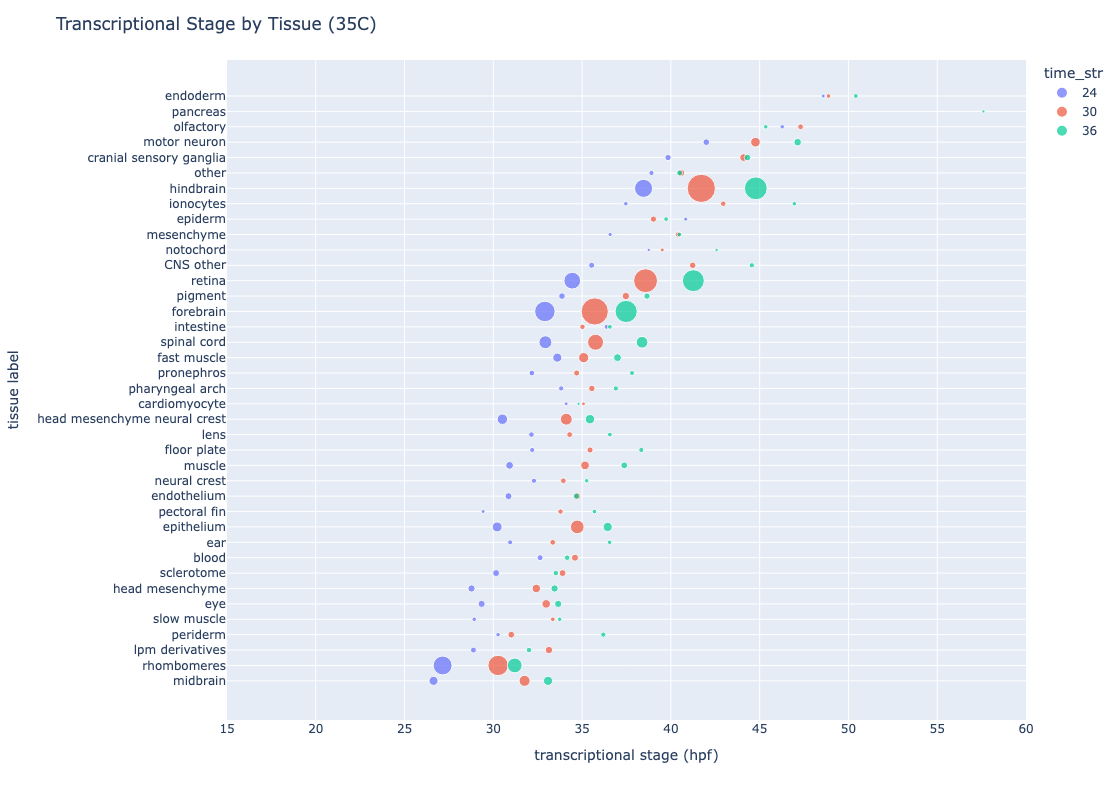

In [12]:
temp_vec = np.unique(tissue_stage_df_full["temp"])
tissue_stage_df_full["time_str"] = tissue_stage_df_full["timepoint"].astype(str)

for plot_temp in temp_vec:
    fig = px.scatter(tissue_stage_df_full.loc[tissue_stage_df_full["temp"]==plot_temp, :], x="nn_time_mean", 
                     y="tissue", color="time_str", size="n_cells_plot")
    fig.update_layout(width=800, height=800) 
    fig.update_layout(
        xaxis=dict(range=[15, 60]),
        title=f"Transcriptional Stage by Tissue ({plot_temp}C)"
    )

    fig.update_layout(
        yaxis_title="tissue label",
        xaxis_title="transcriptional stage (hpf)"
    )
    fig.write_image(fig_folder + f"tissue_stages_{plot_temp}C.png", scale=2)
    fig.write_html(fig_folder + f"tissue_stages_{plot_temp}C.html")

fig.show()

Now flip it around and plot all temps for each timepoint

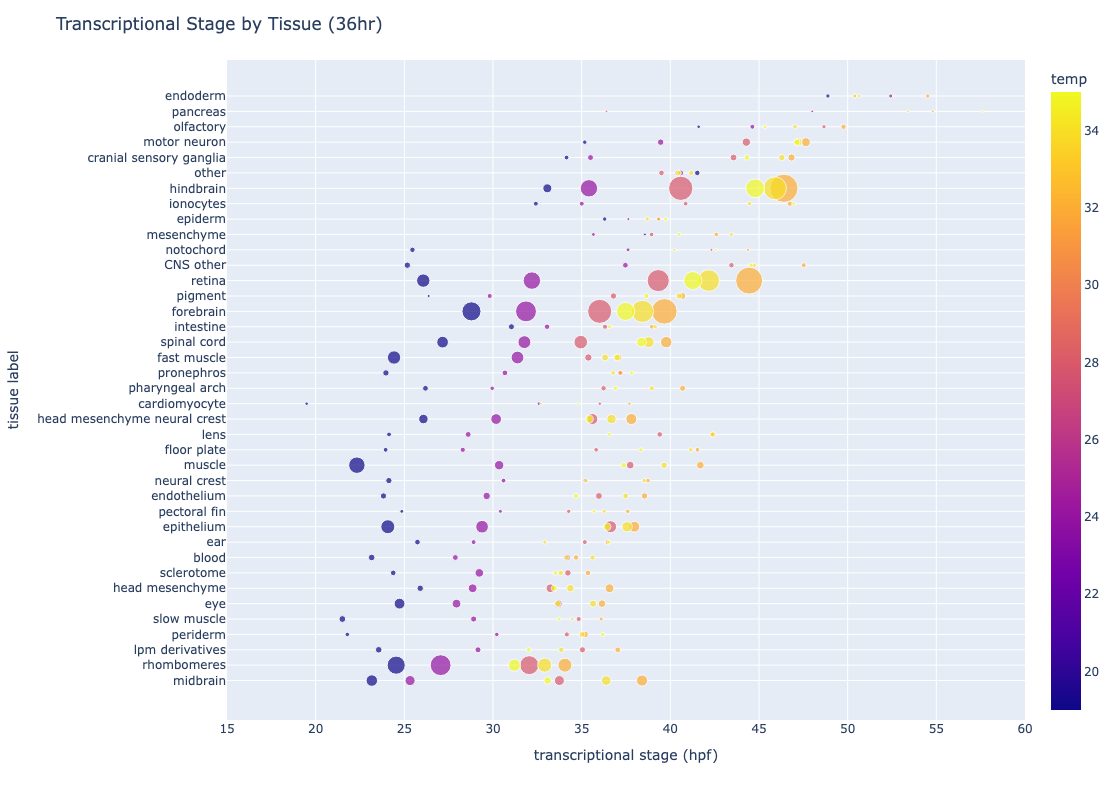

In [13]:
time_vec = np.unique(tissue_stage_df_full["timepoint"])
# tissue_stage_df_full["time_str"] = tissue_stage_df_full["timepoint"].astype(str)
# plot_time = 24
for plot_time in time_vec:
    fig = px.scatter(tissue_stage_df_full.loc[tissue_stage_df_full["timepoint"]==plot_time, :], x="nn_time_mean", 
                     y="tissue", color="temp", size="n_cells_plot")
    fig.update_layout(width=800, height=800) 
    fig.update_layout(
        xaxis=dict(range=[15, 60]),
        title=f"Transcriptional Stage by Tissue ({plot_time}hr)"
    )

    fig.update_layout(
        yaxis_title="tissue label",
        xaxis_title="transcriptional stage (hpf)"
    )
    
    fig.write_image(fig_folder + f"time_tissue_stages_{plot_time}hr.png", scale=2)
    fig.write_html(fig_folder + f"time_tissue_stages_{plot_time}hr.html")

fig.show()

**Now let's look at drivers of variability in the higher temps**

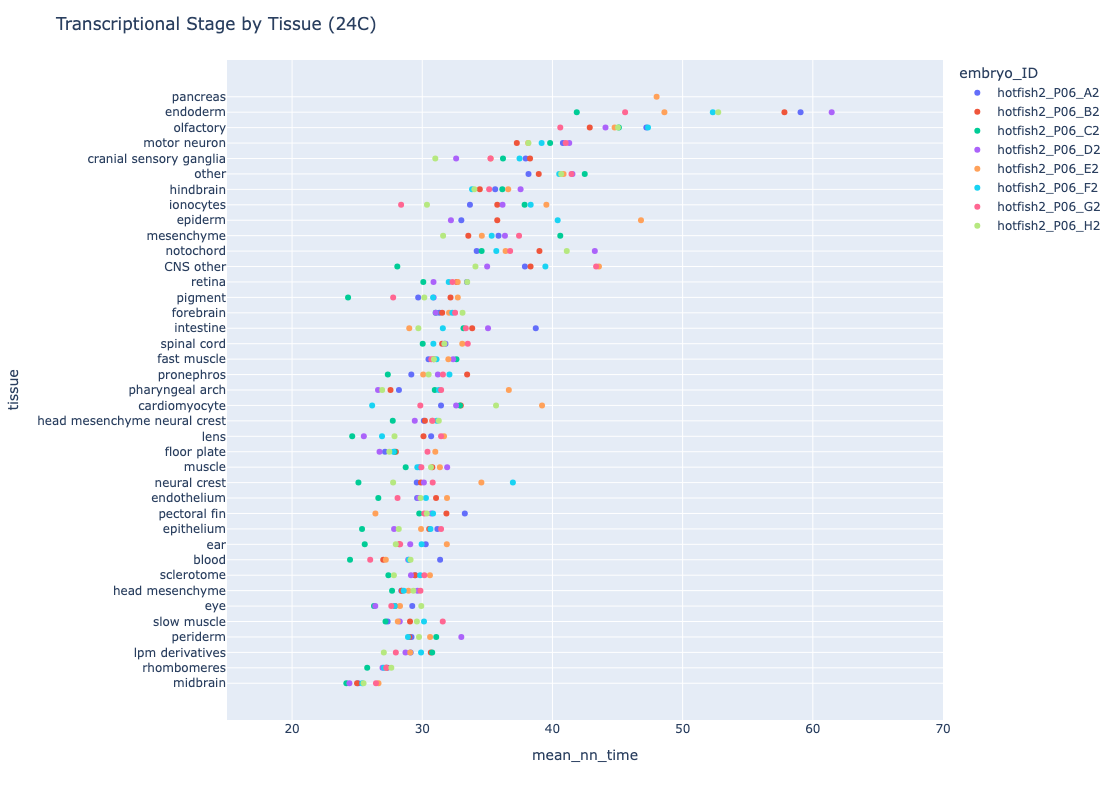

In [9]:
plot_temp = 24
plot_time = 36

plot_filter = (tissue_stage_df0_full["temp"]==plot_temp) & (tissue_stage_df0_full["timepoint"]==plot_time)

tissue_stage_df0_full["time_str"] = tissue_stage_df0_full["timepoint"].astype(str)

fig = px.scatter(tissue_stage_df0_full.loc[plot_filter, :], x="mean_nn_time", 
                     y="tissue", color="embryo_ID")

fig.update_layout(width=800, height=800) 

fig.update_layout(
    xaxis=dict(range=[15, 70]),
    title=f"Transcriptional Stage by Tissue ({plot_temp}C)"
)

fig.update_layout(
        yaxis_title="tissue label",
        xaxis_title="transcriptional stage (hpf)"
    )

# fig.write_image(fig_folder + f"tissue_stages_{plot_temp}C.png", scale=2)
# fig.write_html(fig_folder + f"tissue_stages_{plot_temp}C.html")

### Look at embryo-to-embryo variability as a function of time and temp

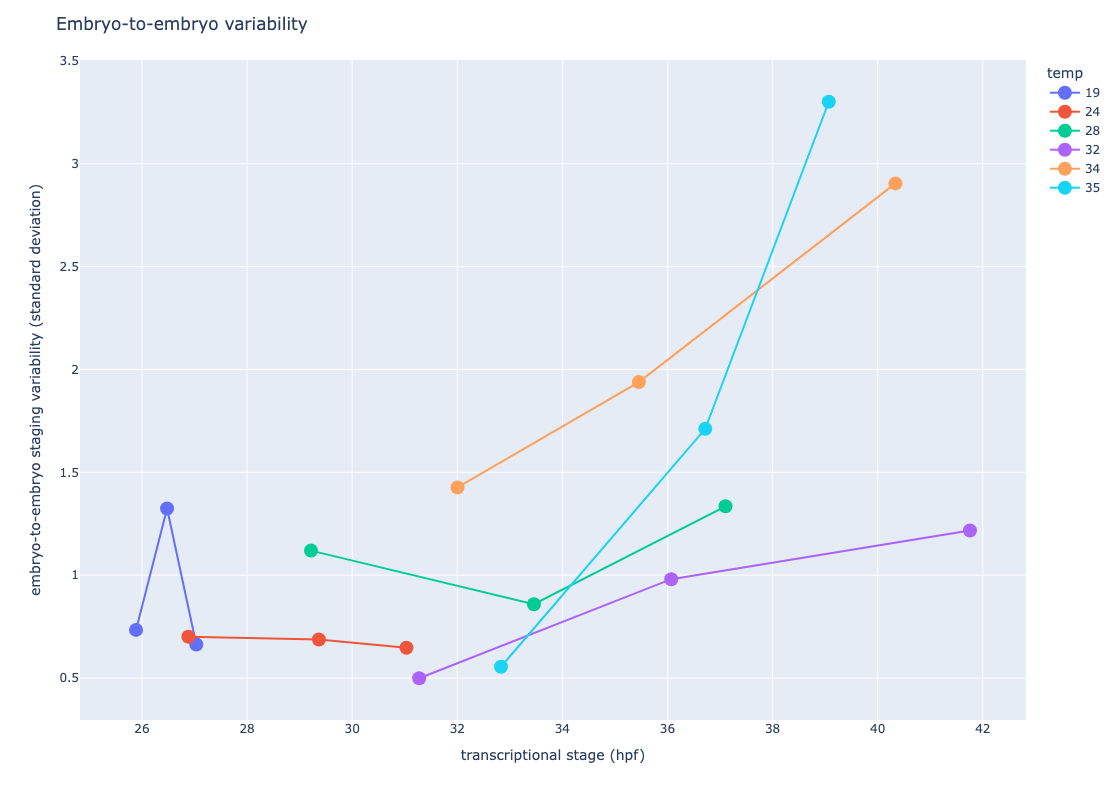

In [17]:
# get average time for each embryo
emb_stage_df = col_df.loc[:, ["embryo_ID", "temp", "timepoint", "mean_nn_time"]].groupby(
                    ["embryo_ID", "temp", "timepoint"])["mean_nn_time"].agg(["mean", "std"]).reset_index()

emb_stage_df = emb_stage_df.rename(columns={"mean":"mean_nn_time", "std":"std_nn_time"})


# now aggregate at cohort level
grp_stage_df = emb_stage_df.loc[:, ["temp", "timepoint", "mean_nn_time", "std_nn_time"]].groupby(
                    ["temp", "timepoint"]).agg(
                        mean_nn_time=('mean_nn_time', 'mean'),
                        emb_time_std=('mean_nn_time', 'std'),
                        cell_time_std=('std_nn_time', 'mean')
                    ).reset_index()


fig = px.line(grp_stage_df, x="mean_nn_time", y="emb_time_std", color="temp", markers=True)
# fig.add_trace(go.Scatter(x=ref_vec, y=ref_vec, mode="lines", line=dict(color="black", width=2, dash="dash")))
fig.update_traces(marker=dict(size=14))
fig.update_layout(width=800, height=800) 

fig.update_layout(
    title=f"Embryo-to-embryo variability"
)

fig.update_layout(
        yaxis_title="embryo-to-embryo staging variability (standard deviation)",
        xaxis_title="transcriptional stage (hpf)"
    )

fig.show()

fig.write_image(fig_folder + "inter_embryo_variability.png", scale=2)
fig.write_html(fig_folder + "inter_embryo_variability.html")

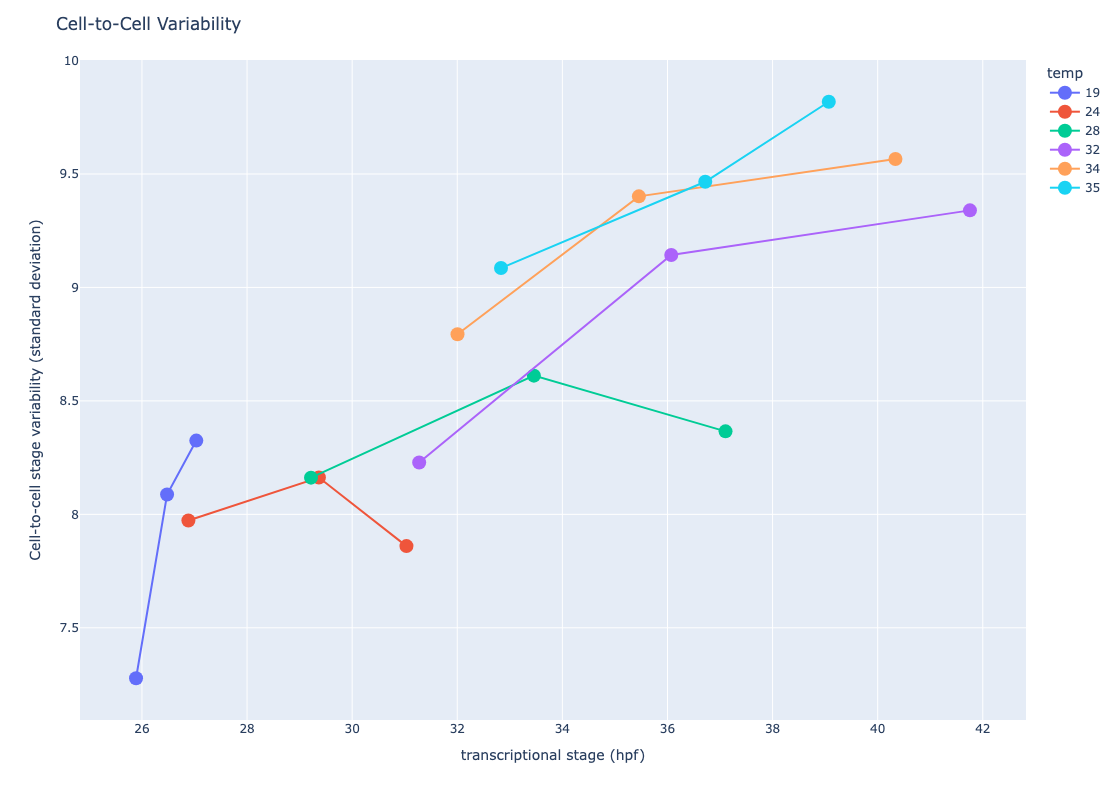

In [18]:
fig = px.line(grp_stage_df, x="mean_nn_time", y="cell_time_std", color="temp", markers=True)
# fig.add_trace(go.Scatter(x=ref_vec, y=ref_vec, mode="lines", line=dict(color="black", width=2, dash="dash")))
fig.update_traces(marker=dict(size=14))
fig.update_layout(width=800, height=800) 

fig.update_layout(
    title=f"Cell-to-Cell Variability"
)

fig.update_layout(
        yaxis_title="Cell-to-cell stage variability (standard deviation)",
        xaxis_title="transcriptional stage (hpf)"
    )


fig.show()

fig.write_image(fig_folder + "intra_embryo_variability.png", scale=2)
fig.write_html(fig_folder + "intra_embryo_variability.html")

### Look at pairwise correlations between tissue stages

In [234]:
from tqdm import tqdm

n_emb_thresh = 8

# grouped table
emb_tissue_stage_df = col_df.loc[:, ["embryo_ID", "tissue", "temp", "timepoint", "mean_nn_time"]].groupby(
                    ["embryo_ID", "tissue", "temp", "timepoint"])["mean_nn_time"].agg(["mean", "size"]).reset_index()

# rename
emb_tissue_stage_df = emb_tissue_stage_df.rename(columns={"mean":"mean_nn_time", "size":"n_cells"})

# Get unique values for temp, timepoint, and tissue
# temp_values = emb_tissue_stage_df['temp'].unique()
# timepoint_values = emb_tissue_stage_df['timepoint'].unique()
tissue_values = emb_tissue_stage_df['tissue'].unique()  # Unique tissue values
embryo_values = emb_tissue_stage_df['embryo_ID'].unique()

# Create a Cartesian product of all combinations
complete_index = pd.DataFrame(list(product(tissue_values, embryo_values)),
                               columns=['tissue', "embryo_ID"])

# Merge the original data with the complete index
emb_tissue_stage_df = pd.merge(complete_index, emb_tissue_stage_df, on=['tissue', 'embryo_ID'], how='left')

# calculate correlation coefficients
temp_vec = np.asarray(sorted(emb_tissue_stage_df["temp"].unique())).astype(float)
temp_vec = temp_vec[~np.isnan(temp_vec)]
cc_mat_list = []
cov_mat_list = []
count_mat_list = []
for temp in tqdm(temp_vec):

    temp_df = emb_tissue_stage_df.loc[emb_tissue_stage_df["temp"] == temp, ["embryo_ID", "tissue", "mean_nn_time"]]
    # mu = np.mean(temp_df["mean_nn_time"])
    temp_df["mean_nn_time"] = temp_df["mean_nn_time"] - mu
    # Step 1: Pivot the data so that each tissue is a column
    pivot_df = temp_df.pivot(index='embryo_ID', columns='tissue', values='mean_nn_time')
    
    # Step 2: Compute pairwise Pearson correlations between tissues
    correlation_matrix = pivot_df.corr(method='pearson').reset_index()
    covariance_matrix = pivot_df.cov().reset_index()

    # Step 3: Calculate the count matrix (number of shared `embryo_ID`s for each pair)
    bool_df = pivot_df.notna()
    
    # Explicitly convert Boolean to integers (True -> 1, False -> 0)
    int_df = bool_df.astype(int)
    count_matrix = int_df.T.dot(int_df)
    count_mat_list.append(count_matrix.to_numpy())
    
    # # Step 4: Apply a threshold for counts (e.g., at least 3 shared `embryo_ID`s)
    # correlation_matrix[count_matrix < n_emb_thresh] = np.nan
    cv = covariance_matrix.set_index("tissue")
    cc_mat_list.append(correlation_matrix.set_index("tissue"))
    cov_mat_list.append(cv)

100%|██████████| 6/6 [00:00<00:00, 474.16it/s]


In [235]:
mu

np.float64(36.317482194703906)

In [236]:
# filter out low-obs tissues
stacked_counts = np.stack(count_mat_list, axis=2)
min_count_array = np.squeeze(np.min(stacked_counts, axis=2))
filter_vec = np.max(min_count_array, axis=0) >= n_emb_thresh
colnames = np.asarray(cc_mat_list[0].columns)
filter_vec = filter_vec & (colnames !="other")

for t in range(len(temp_vec)):
    # corr
    cc_temp = cc_mat_list[t].copy()
    cols = np.asarray(cc_temp.columns)
    cc_temp = cc_temp.loc[filter_vec, cols[filter_vec]]
    cc_mat_list[t] = cc_temp

    # cov
    cv_temp = cov_mat_list[t].copy()
    cols = np.asarray(cv_temp.columns)
    cv_temp = cv_temp.loc[filter_vec, cols[filter_vec]]
    cov_mat_list[t] = cv_temp

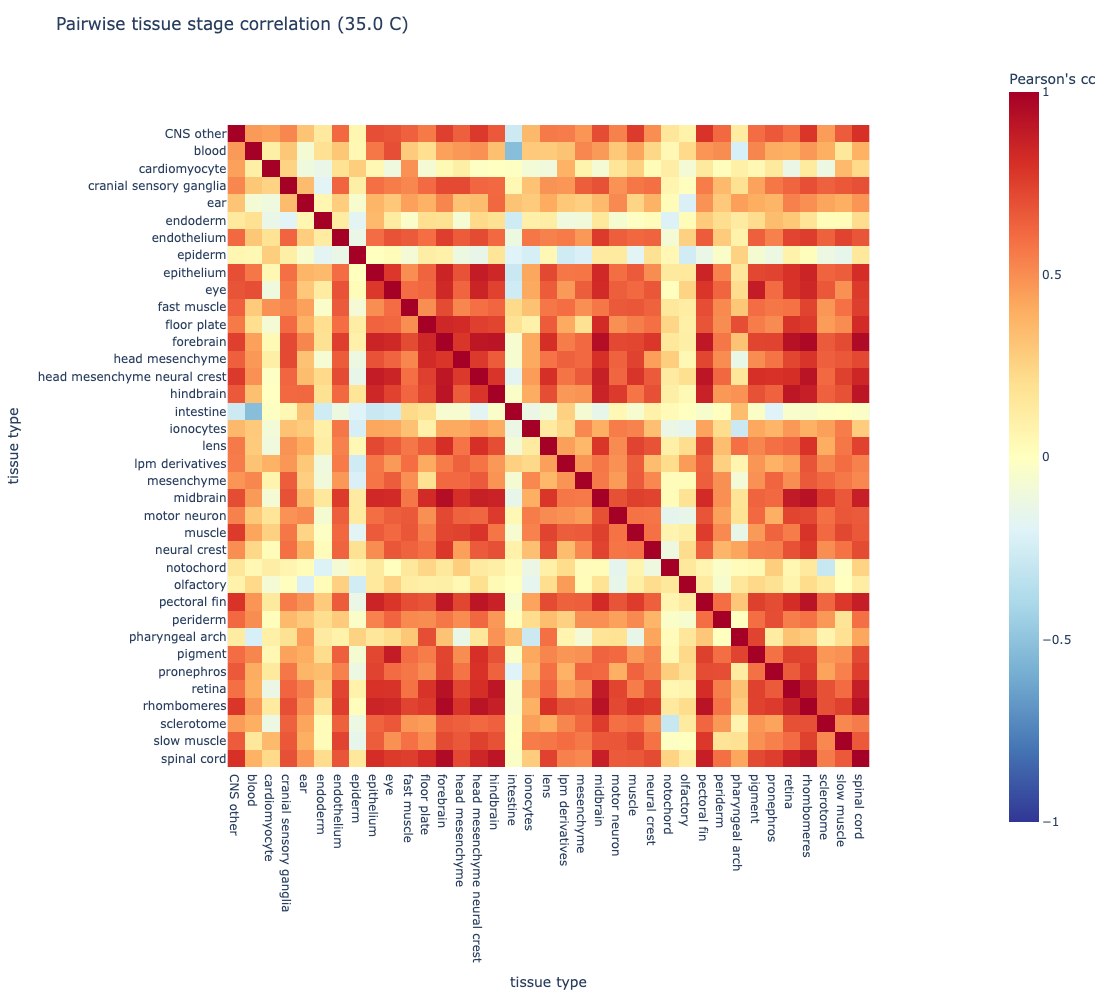

In [255]:
for t, temp in enumerate(temp_vec):

    fig = px.imshow(cc_mat_list[t], color_continuous_scale="RdYlBu_r")
    fig.update_layout(width=1000, height=1000) 
    fig.update_layout(title=f"Pairwise tissue stage correlation ({temp} C)")

    # Hide axis titles
    fig.update_layout(
        xaxis_title="tissue type",  
        yaxis_title="tissue type",  
        coloraxis_colorbar_title="Pearson's cc",
        coloraxis=dict(cmin=-1, cmax=1) 
    )

    fig.write_image(fig_folder + f"tissue_cc_{int(temp)}C.png", scale=2)
    fig.write_html(fig_folder + f"tissue_cc_{int(temp)}C.html")

fig.show()

### look at distribution of CC's across the different temps

In [238]:
cc_list = []
for t, temp in enumerate(temp_vec): 
    cc = cc_mat_list[t].to_numpy()
    tril_indices = np.tril_indices(cc.shape[0], k=-1)
    cc_vals = cc[tril_indices]
    cc_df = pd.DataFrame(cc_vals[cc_vals<1], columns=["cc"])
    cc_df["temp"] = temp
    cc_list.append(cc_df)

cc_df = pd.concat(cc_list, axis=0, ignore_index=True)
# cc_df["temp"] = pd.Categorical(cc_df["temp"])
cc_df.head()

cc  temp
0  0.318019  19.0
1  0.251797  19.0
2  0.374721  19.0
3  0.012261  19.0
4 -0.387154  19.0

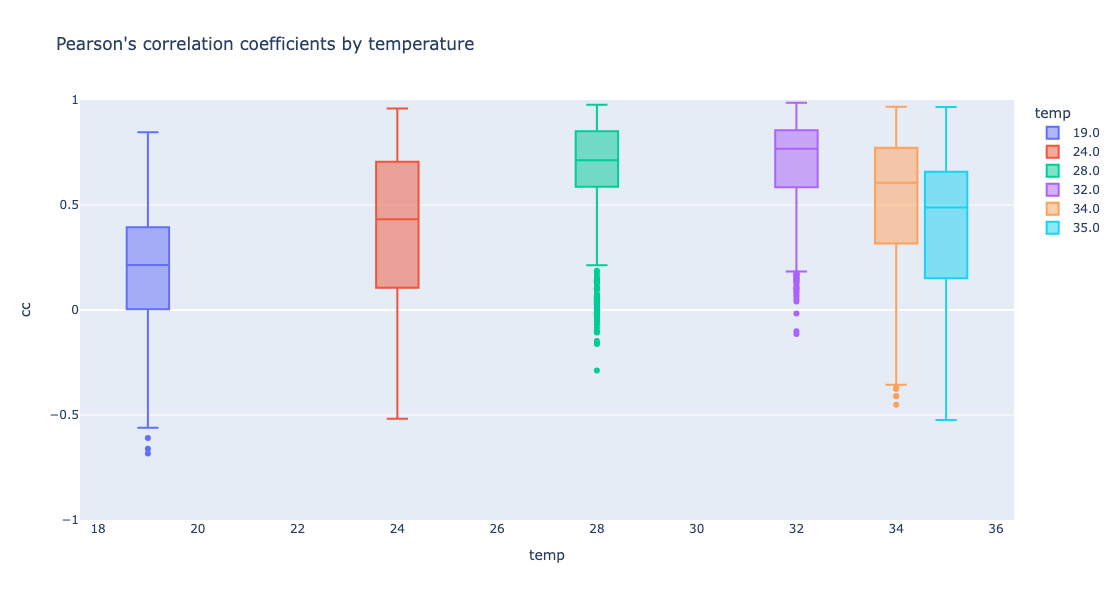

In [239]:
# Create a violin plot
fig = px.box(
    cc_df,
    y="cc",  # Variable for the y-axis
    x="temp",  # Grouping variable,
    color="temp",
    title="Pearson's correlation coefficients by temperature"
)

# fig.update_traces(meanline_visible=True)  # Show mean line
fig.update_traces(width=0.85)  # Adjust width for all violin traces

fig.update_layout(width=800, height=600, 
                  coloraxis_colorbar_title="temperature",
                  yaxis=dict(range=[-1, 1])) 

fig.write_image(fig_folder + f"tissue_cc_violin.png", scale=2)
fig.write_html(fig_folder + f"tissue_cc_violin.html")

fig.show()

In [262]:
# calculate the entropy for each tempera
entropy_vec = []
entropy_vec_r = []
for t, temp in enumerate(temp_vec): 
    cc = cc_mat_list[t].to_numpy()
    # cv += np.eye(cv.shape[0]) 
    cv_r = np.multiply(cv, np.eye(cv.shape[0]))
    dt = np.linalg.det(cv)

    # entropy = np.log2(dt) / 2 # cv.shape[0] / 2 * np.log2(2*np.pi*np.exp(1))
    # print(entropy)

    # calculate determinant
    # U, s, Vt = np.linalg.svd(cv)
    # log_det = np.sum(np.log(s))  # Sum of log(singular values)
    # dt = np.exp(log_det) 
    # L = np.linalg.cholesky(cv)
    # log_det = 2 * np.sum(np.log(np.diag(L)))
    # dt = np.exp(log_det)  

    entropy = np.log2(dt) / 2 + cv.shape[0] / 2 * np.log2(2*np.pi*np.exp(1))
    entropy_vec.append(entropy)

    # do the same for the diagonal matrix
    dt_r = np.linalg.det(cv_r)
    entropy_r = np.log2(dt_r) / 2 + cv.shape[0] / 2 * np.log2(2*np.pi*np.exp(1))
    entropy_vec_r.append(entropy_r)
    
    
cv_df = pd.DataFrame(entropy_vec, columns=["entropy"])
cv_df["entropy_null"] = entropy_vec_r
cv_df["info_gain"] =  cv_df["entropy_null"] - cv_df["entropy"]
cv_df["temp"] = temp_vec
# cc_df["temp"] = pd.Categorical(cc_df["temp"])
cv_df


entropy  entropy_null  info_gain  temp
0  111.683408    145.160406  33.476998  19.0
1  111.683408    145.160406  33.476998  24.0
2  111.683408    145.160406  33.476998  28.0
3  111.683408    145.160406  33.476998  32.0
4  111.683408    145.160406  33.476998  34.0
5  111.683408    145.160406  33.476998  35.0

In [263]:
cc_mat_list[t]==cc_mat_list[t-1]

tissue                        CNS other  blood  cardiomyocyte  \
tissue                                                          
CNS other                          True  False          False   
blood                             False   True          False   
cardiomyocyte                     False  False           True   
cranial sensory ganglia           False  False          False   
ear                               False  False          False   
endoderm                          False  False          False   
endothelium                       False  False          False   
epiderm                           False  False          False   
epithelium                        False  False          False   
eye                               False  False          False   
fast muscle                       False  False          False   
floor plate                       False  False          False   
forebrain                         False  False          False   
head mesenchyme                   False  False          False   
head mesenchyme neural crest      False  False          False   
hindbrain                         False  False          False   
intestine                         False  False          False   
ionocytes                         False  False          False   
lens                              False  False          False   
lpm derivatives                   False  False          False   
mesenchyme                        False  False          False   
midbrain                          False  False          False   
motor neuron                      False  False          False   
muscle                            False  False          False   
neural crest                      False  False          False   
notochord                         False  False          False   
olfactory                         False  False          False   
pectoral fin                      False  False          False   
periderm                          False  False          False   
pharyngeal arch                   False  False          False   
pigment                           False  False          False   
pronephros                        False  False          False   
retina                            False  False          False   
rhombomeres                       False  False          False   
sclerotome                        False  False          False   
slow muscle                       False  False          False   
spinal cord                       False  False          False   

tissue                        cranial sensory ganglia    ear  endoderm  \
tissue                                                                   
CNS other                                       False  False     False   
blood                                           False  False     False   
cardiomyocyte                                   False  False     False   
cranial sensory ganglia                          True  False     False   
ear                                             False   True     False   
endoderm                                        False  False      True   
endothelium                                     False  False     False   
epiderm                                         False  False     False   
epithelium                                      False  False     False   
eye                                             False  False     False   
fast muscle                                     False  False     False   
floor plate                                     False  False     False   
forebrain                                       False  False     False   
head mesenchyme                                 False  False     False   
head mesenchyme neural crest                    False  False     False   
hindbrain                                       False  False     False   
intestine                                       False  False     False   
ionocytes                                       False  Fal

In [261]:
cc

array([[ 1.        ,  0.46156095,  0.4413319 , ...,  0.45350425,
         0.65836069,  0.8002295 ],
       [ 0.46156095,  1.        ,  0.10425989, ...,  0.39426903,
         0.15037634,  0.3852237 ],
       [ 0.4413319 ,  0.10425989,  1.        , ..., -0.12088871,
         0.35082589,  0.22450465],
       ...,
       [ 0.45350425,  0.39426903, -0.12088871, ...,  1.        ,
         0.51688756,  0.55557862],
       [ 0.65836069,  0.15037634,  0.35082589, ...,  0.51688756,
         1.        ,  0.66417453],
       [ 0.8002295 ,  0.3852237 ,  0.22450465, ...,  0.55557862,
         0.66417453,  1.        ]])

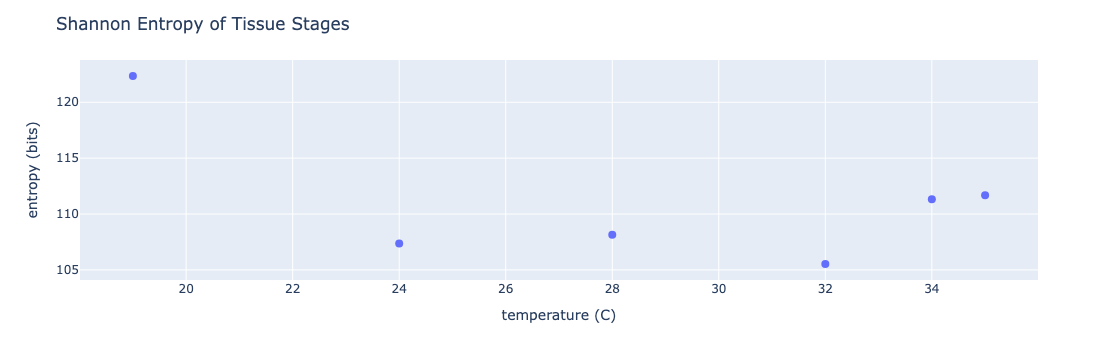

In [257]:
fig = px.scatter(cv_df, x="temp", y="entropy")

fig.update_layout(
        yaxis_title="entropy (bits)",  
        xaxis_title="temperature (C)",
        title="Shannon Entropy of Tissue Stages"
    )

fig.update_traces(marker=dict(size=8))
fig.show()

fig.write_image(fig_folder + f"embryo_stage_info.png", scale=2)
fig.write_html(fig_folder + f"embryo_stage_info.html")

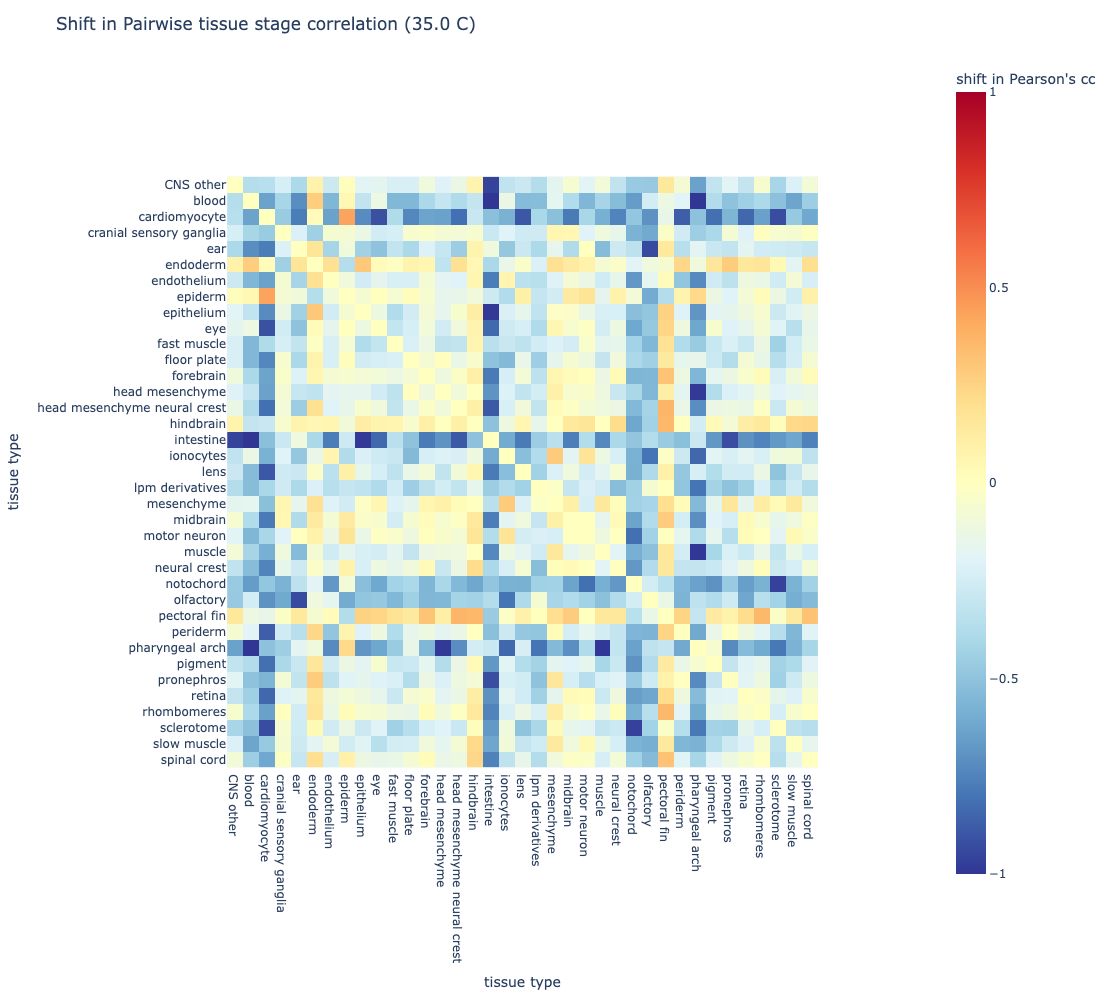

In [254]:
# plot differences in CC, using 28C as reference
ref_temp = 28
ref_ind = np.where(temp_vec==ref_temp)[0][0]
cc_ref = cc_mat_list[ref_ind]

for t, temp in enumerate(temp_vec):

    if temp != ref_temp:
        cc = cc_mat_list[t]
        dc = cc - cc_ref
        fig = px.imshow(dc, color_continuous_scale="RdYlBu_r")
        fig.update_layout(width=1000, height=1000) 
        fig.update_layout(title=f"Shift in Pairwise tissue stage correlation ({temp} C)")
    
        # Hide axis titles
        fig.update_layout(
            xaxis_title="tissue type",  
            yaxis_title="tissue type",  
            coloraxis_colorbar_title="shift in Pearson's cc",
            coloraxis=dict(cmin=-1, cmax=1) 
        )
    
        fig.write_image(fig_folder + f"tissue_delta_cc_{int(temp)}C.png", scale=2)
        fig.write_html(fig_folder + f"tissue_delta_cc_{int(temp)}C.html")

fig.show()

In [250]:
ref_ind

np.int64(2)

#### Recreate cell type stage plots from Dorrity et al.

In [25]:
# grouped table
# col_df["cell_type"] = col_df["cell_type"].astype(str)
cell_stage_df = col_df.loc[:, ["embryo_ID", "tissue", "cell_type", "temp", "timepoint", "mean_nn_time"]].groupby(
                    ["embryo_ID", "tissue", "cell_type", "temp", "timepoint"])["mean_nn_time"].agg(["mean", "size"]).reset_index()

# rename
cell_stage_df = cell_stage_df.rename(columns={"mean":"mean_nn_time", "size":"n_cells"})

# now group by cohort
cell_stage_df = cell_stage_df.loc[:, ["tissue", "cell_type", "temp", "timepoint", "mean_nn_time", "n_cells"]].groupby(
                                     ["cell_type", "tissue", "temp", "timepoint"]).agg(
                        nn_time_mean=('mean_nn_time', 'mean'),
                        nn_time_25=('mean_nn_time', lambda x: x.quantile(0.25)),
                        nn_time_75=('mean_nn_time', lambda x: x.quantile(0.75)),
                        n_cells=('n_cells', 'mean')
                    ).reset_index()

# calculate relative shift between 28C and 34C for ranking purposes
filter34 = (cell_stage_df["timepoint"]==24) & (cell_stage_df["temp"]==34)
diff_df34 = cell_stage_df.loc[filter34, ["cell_type", "nn_time_mean"]] 
diff_df34 = diff_df34.rename(columns={"nn_time_mean":"stage_34C"})
filter28 = (cell_stage_df["timepoint"]==24) & (cell_stage_df["temp"]==28)
diff_df28 = cell_stage_df.loc[filter28, ["cell_type", "nn_time_mean"]] 
diff_df28 = diff_df28.rename(columns={"nn_time_mean":"stage_28C"})

cell_ranks = diff_df34.merge(diff_df28, how="inner", on="cell_type")
cell_ranks["time_shift"] = cell_ranks["stage_34C"] - cell_ranks["stage_28C"]
cell_ranks["time_fold"] = np.divide(cell_ranks["stage_34C"], cell_ranks["stage_28C"])
cell_ranks.head()

cell_ranks['cell_rank'] = cell_ranks['time_shift'].rank()

# # now get overall averages for ranking purposes
# cell_ranks = diff_df.loc[:, ["cell_type", "stage_rank"]].groupby("cell_type").mean().reset_index()
# cell_ranks["cell_rank"] = cell_ranks["stage_rank"].rank()

# convert to factor
cell_ranks["cell_type"] = pd.Categorical(cell_ranks["cell_type"])
cell_stage_df["cell_type"] = pd.Categorical(cell_stage_df["cell_type"])

# Get unique values for temp, timepoint, and tissue
temp_values = cell_stage_df['temp'].unique()
timepoint_values = cell_stage_df['timepoint'].unique()
cell_values = cell_stage_df['cell_type'].cat.categories  # Unique tissue values

# Create a Cartesian product of all combinations
complete_index = pd.DataFrame(list(product(temp_values, timepoint_values, cell_values)),
                               columns=['temp', 'timepoint', 'cell_type'])

# Merge the original data with the complete index
cell_stage_df_full = pd.merge(complete_index, cell_stage_df, on=['temp', 'timepoint', 'cell_type'], how='left')

cell_stage_df_full = cell_stage_df_full.merge(cell_ranks.loc[:, ["cell_type", "cell_rank"]].drop_duplicates(), how="inner", on="cell_type").sort_values(
    by=['temp', "timepoint", 'cell_rank'])

cell_stage_df_full.loc[np.isnan(cell_stage_df_full["n_cells"]), ["n_cells"]] = 0
cell_stage_df_full["n_cells_plot"] = 5 + cell_stage_df_full["n_cells"]

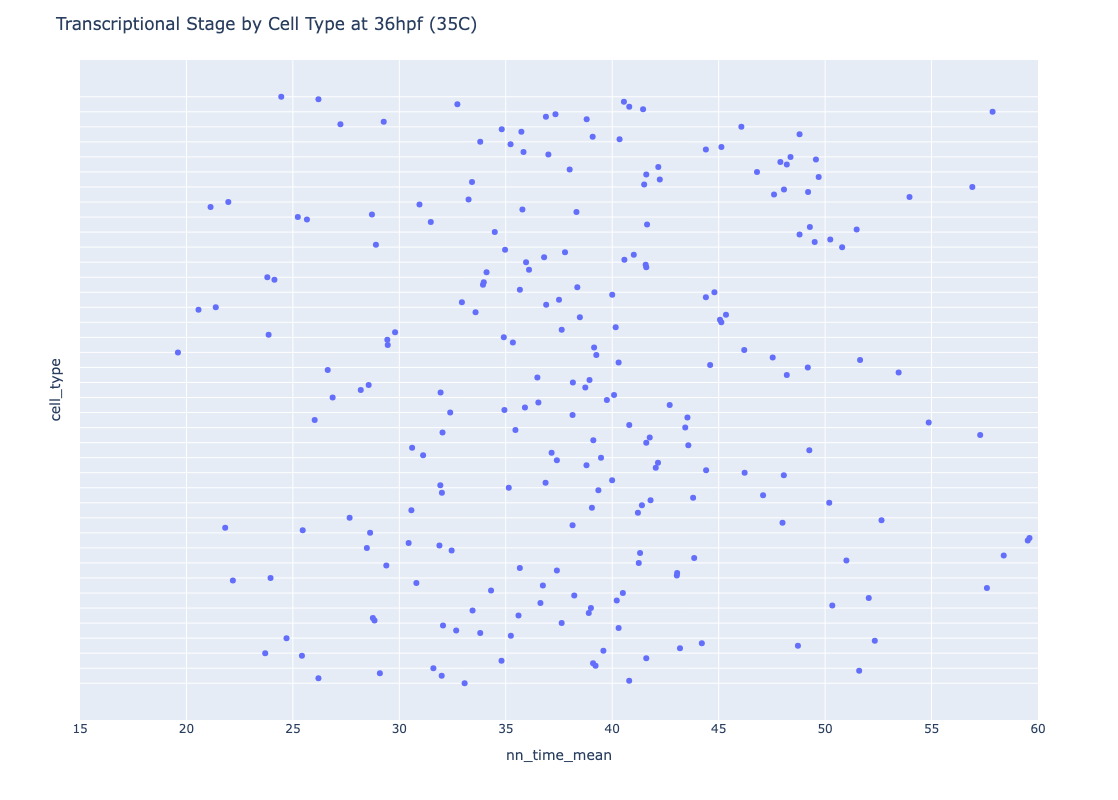

In [23]:
time_vec = np.unique(cell_stage_df_full["timepoint"])
# tissue_stage_df_full["time_str"] = tissue_stage_df_full["timepoint"].astype(str)

plot_temp = 35
plot_time = 36

plot_filter = (cell_stage_df["temp"]==plot_temp) & (cell_stage_df["timepoint"]==plot_time)


# for plot_time in time_vec:
fig = px.scatter(cell_stage_df.loc[plot_filter, :], x="nn_time_mean", 
                 y="cell_type")
fig.update_layout(width=600, height=800) 
fig.update_traces(marker=dict(size=6))
fig.update_layout(
    showlegend=False,
    xaxis=dict(range=[15, 60]),
    yaxis=dict(showticklabels=False),
    title=f"Transcriptional Stage by Cell Type at {plot_time}hpf ({plot_temp}C)"
)

fig.show()
    
    # fig.write_image(fig_folder + f"time_tissue_stages_{plot_time}hr.png", scale=2)
    # fig.write_html(fig_folder + f"time_tissue_stages_{plot_time}hr.html")

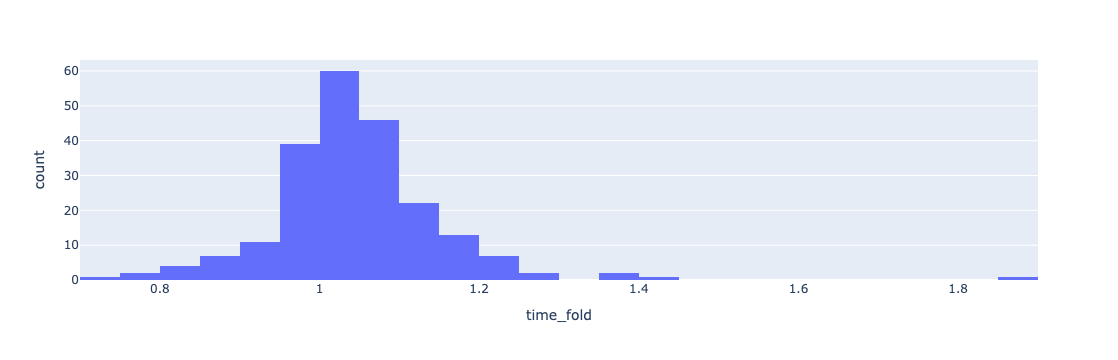

In [26]:
fig = px.histogram(cell_ranks, x="time_fold")
fig.show()

In [27]:
col_df.columns

Index(['cell', 'Size_Factor', 'n.umi', 'perc_mitochondrial_umis',
       'intron_fraction', 'P5_barcode', 'P7_barcode', 'RT_barcode',
       'Ligation_barcode', 'RT_plate', 'hash_umis', 'pval', 'qval',
       'top_to_second_best_ratio', 'top_oligo', 'embryo_ID', 'perturbation',
       'target', 'type', 'allele', 'strain', 'expt', 'cross_batch',
       'collection_batch', 'dis_protocol', 'fix_protocol', 'timepoint',
       'drug_addition', 'stage', 'dose', 'dose_type', 'cold_delay', 'imaging',
       'temp', 'pheno', 'reference', 'published', 'hash_plate', 'hash_well',
       'count_per_embryo', 'log.n.umi', 'max_nn_dist', 'min_nn_dist',
       'projection_group', 'partition_col', 'cell_type', 'mean_nn_time',
       'tissue', 'sample'],
      dtype='object')

In [33]:
len(col_df["cell_type"].unique())

306